In [23]:
import gc
import numpy as np
import pandas as pd
import yfinance as yf
import back_testing as bt
import matplotlib.pyplot as plt

gc.collect()

8746

In [24]:
tickers = ["GC=F", "^GSPC", "LMT"]
data = yf.download(tickers, start="2000-01-01")

[*********************100%***********************]  3 of 3 completed


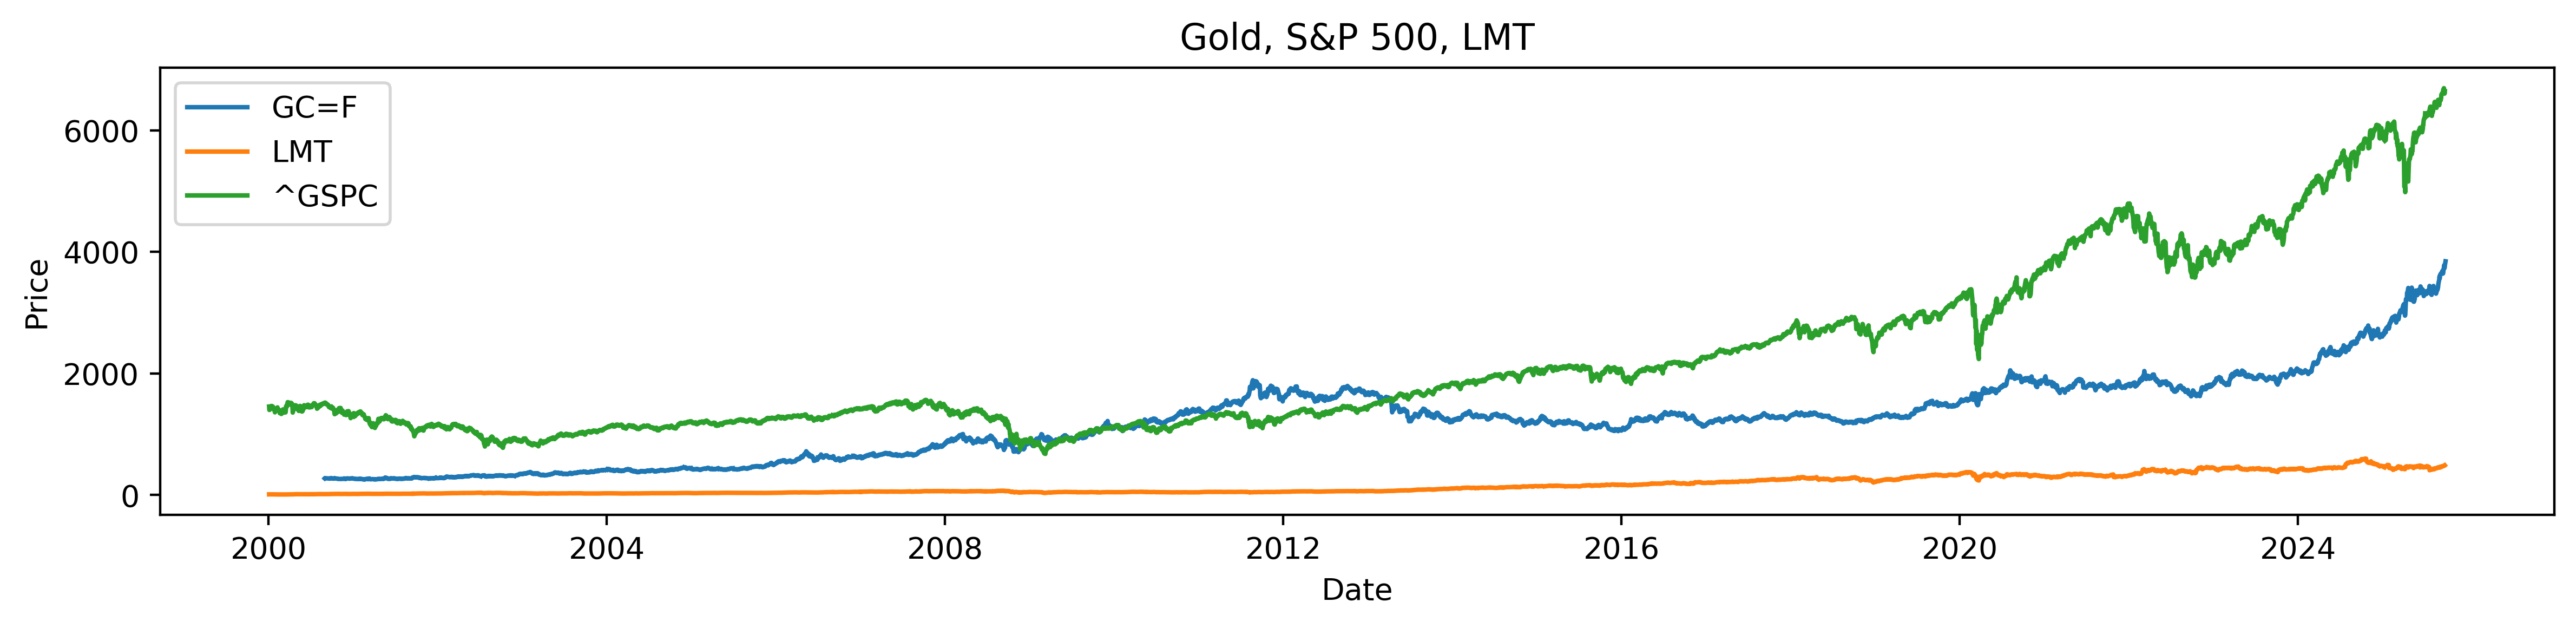

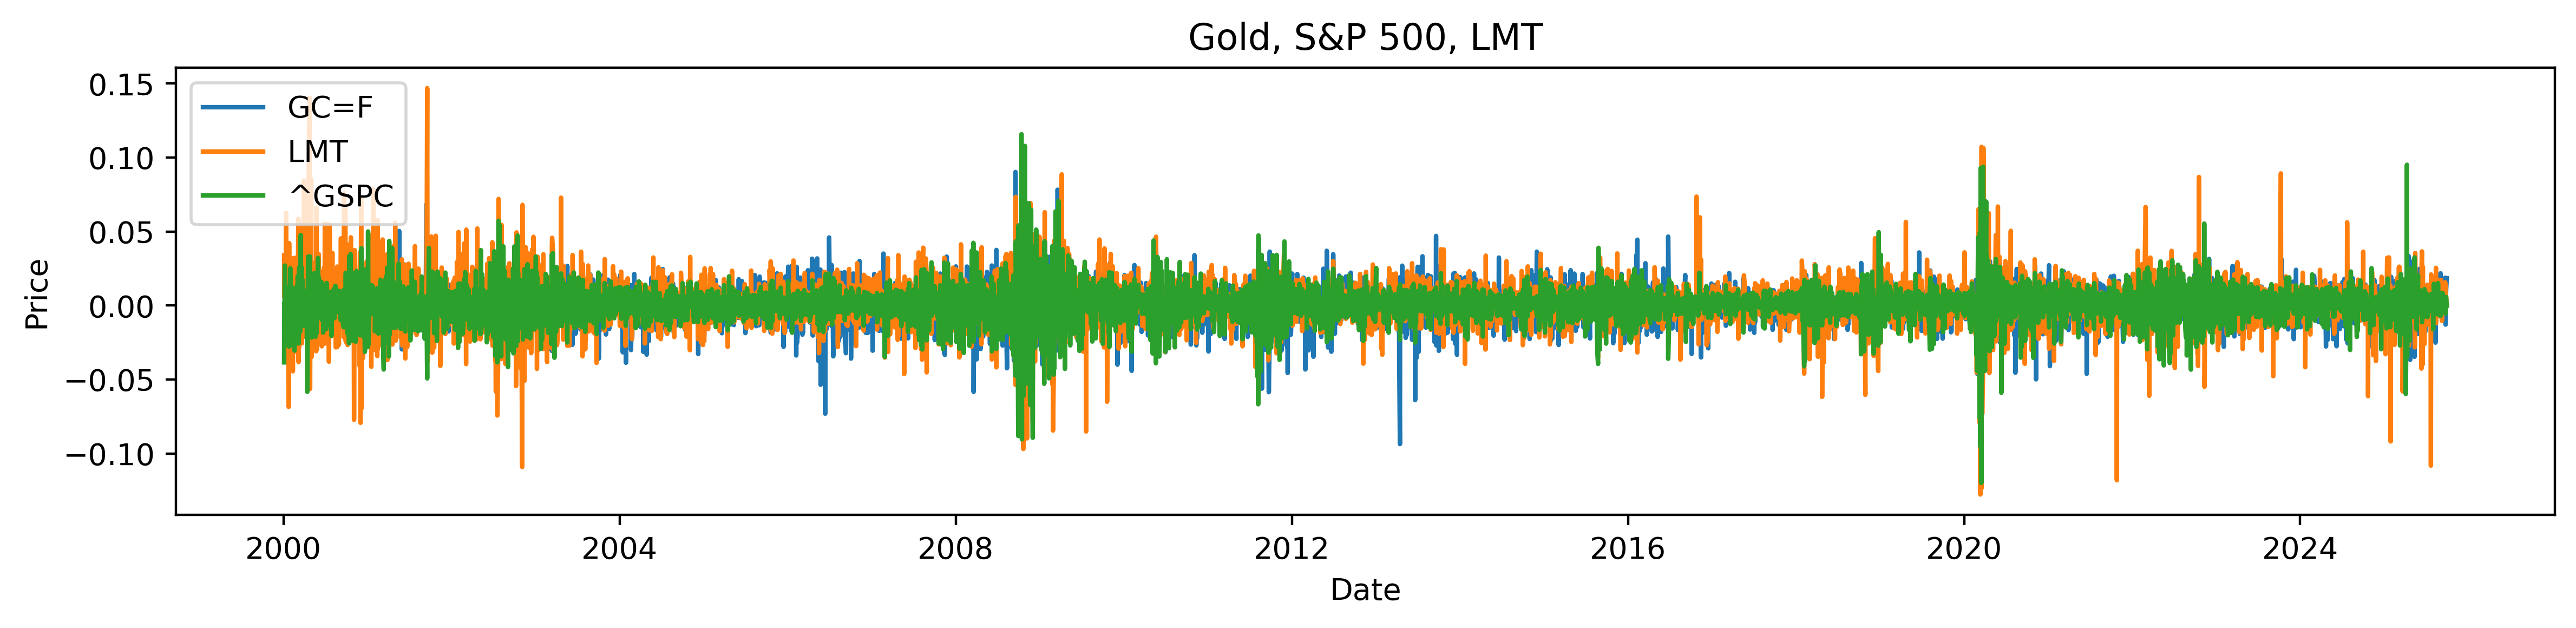

In [25]:
# 시각화
plt.figure(figsize=(12, 3), dpi=400)
plt.plot(data['Close'])
plt.title("Gold, S&P 500, LMT")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(data['Close'].columns, loc='upper left')
plt.tight_layout()
plt.show()

# 시각화
plt.figure(figsize=(12, 3), dpi=400)
plt.plot(data['Close'].pct_change())
plt.title("Gold, S&P 500, LMT")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(data['Close'].columns, loc='upper left')
plt.tight_layout()
plt.show()

In [26]:
# 각 투자 성향별 배분비율 (Gold, S&P500, LMT 순서)
allocation_ratios = {
    'Very_Conservative': [0.8, 0.15, 0.05],  # 매우 보수적: 금 80%, S&P500 15%, LMT 5%
    'Conservative': [0.4, 0.5, 0.1],         # 보수적: 금 40%, S&P500 50%, LMT 10%
    'Balanced': [0.25, 0.5, 0.25],           # 균형: 금 25%, S&P500 50%, LMT 25%
    'Aggressive': [0.1, 0.3, 0.6],           # 공격적: 금 10%, S&P500 30%, LMT 60%
    'Very_Aggressive': [0.05, 0.15, 0.8]     # 매우 공격적: 금 5%, S&P500 15%, LMT 80%
}

start_date = '2000-01-01'
end_date = '2025-06-30'
date_index = pd.date_range(start=start_date, end=end_date, freq='D')
col_order = list(data['Close'].columns)   # 예: ['Gold', 'S&P500', 'LMT']

# 1) 전략별 상수 가중치 테이블들 (weight_dict) — vectorized
weight_dict = {}
for strategy, ratios in allocation_ratios.items():
    arr = np.tile(np.asarray(ratios, dtype=float), (len(date_index), 1))
    strategy_df = pd.DataFrame(arr, index=date_index, columns=col_order)
    weight_dict[strategy] = strategy_df

In [27]:
# Calculate S&P 500 200-day moving average and market conditions
# Add VIX data for market volatility analysis
vix_data = yf.download("^VIX", start="2000-01-01")['Close']

sp500_data = data['Close']['^GSPC'].dropna()
sp500_ma200 = sp500_data.rolling(window=30).mean()

# Create market condition indicators
market_conditions = pd.DataFrame(index=sp500_data.index)
market_conditions['sp500_price'] = sp500_data
market_conditions['sp500_ma200'] = sp500_ma200
market_conditions['above_ma200'] = sp500_data > sp500_ma200
market_conditions['vix'] = vix_data.reindex(sp500_data.index, method='ffill')
market_conditions['vix_high'] = market_conditions['vix'] >= 20

# Create combined market condition
market_conditions['market_regime'] = 'Balanced'  # Default
market_conditions.loc[
    (market_conditions['above_ma200'] == True) & (market_conditions['vix_high'] == False), 
    'market_regime'
] = 'Very_Aggressive'
market_conditions.loc[
    (market_conditions['above_ma200'] == False) & (market_conditions['vix_high'] == True), 
    'market_regime'
] = 'Very_Conservative'

regimes = (
    market_conditions
    .reindex(date_index)[ 'market_regime' ]
    .ffill()
)

#   - 레짐 -> 리스트 매핑 (모르면 Balanced로 대체)
regime_weights_list = regimes.map(
    lambda r: allocation_ratios.get(r, allocation_ratios['Balanced'])
).to_list()

dynamic_weights = pd.DataFrame(regime_weights_list, index=date_index, columns=col_order)

weight_dict['Dynamic'] = dynamic_weights

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed

설정:
  - 기본 수수료: 0.02%
  - Turnover 배수: 1
  - 리밸런싱 주기: W


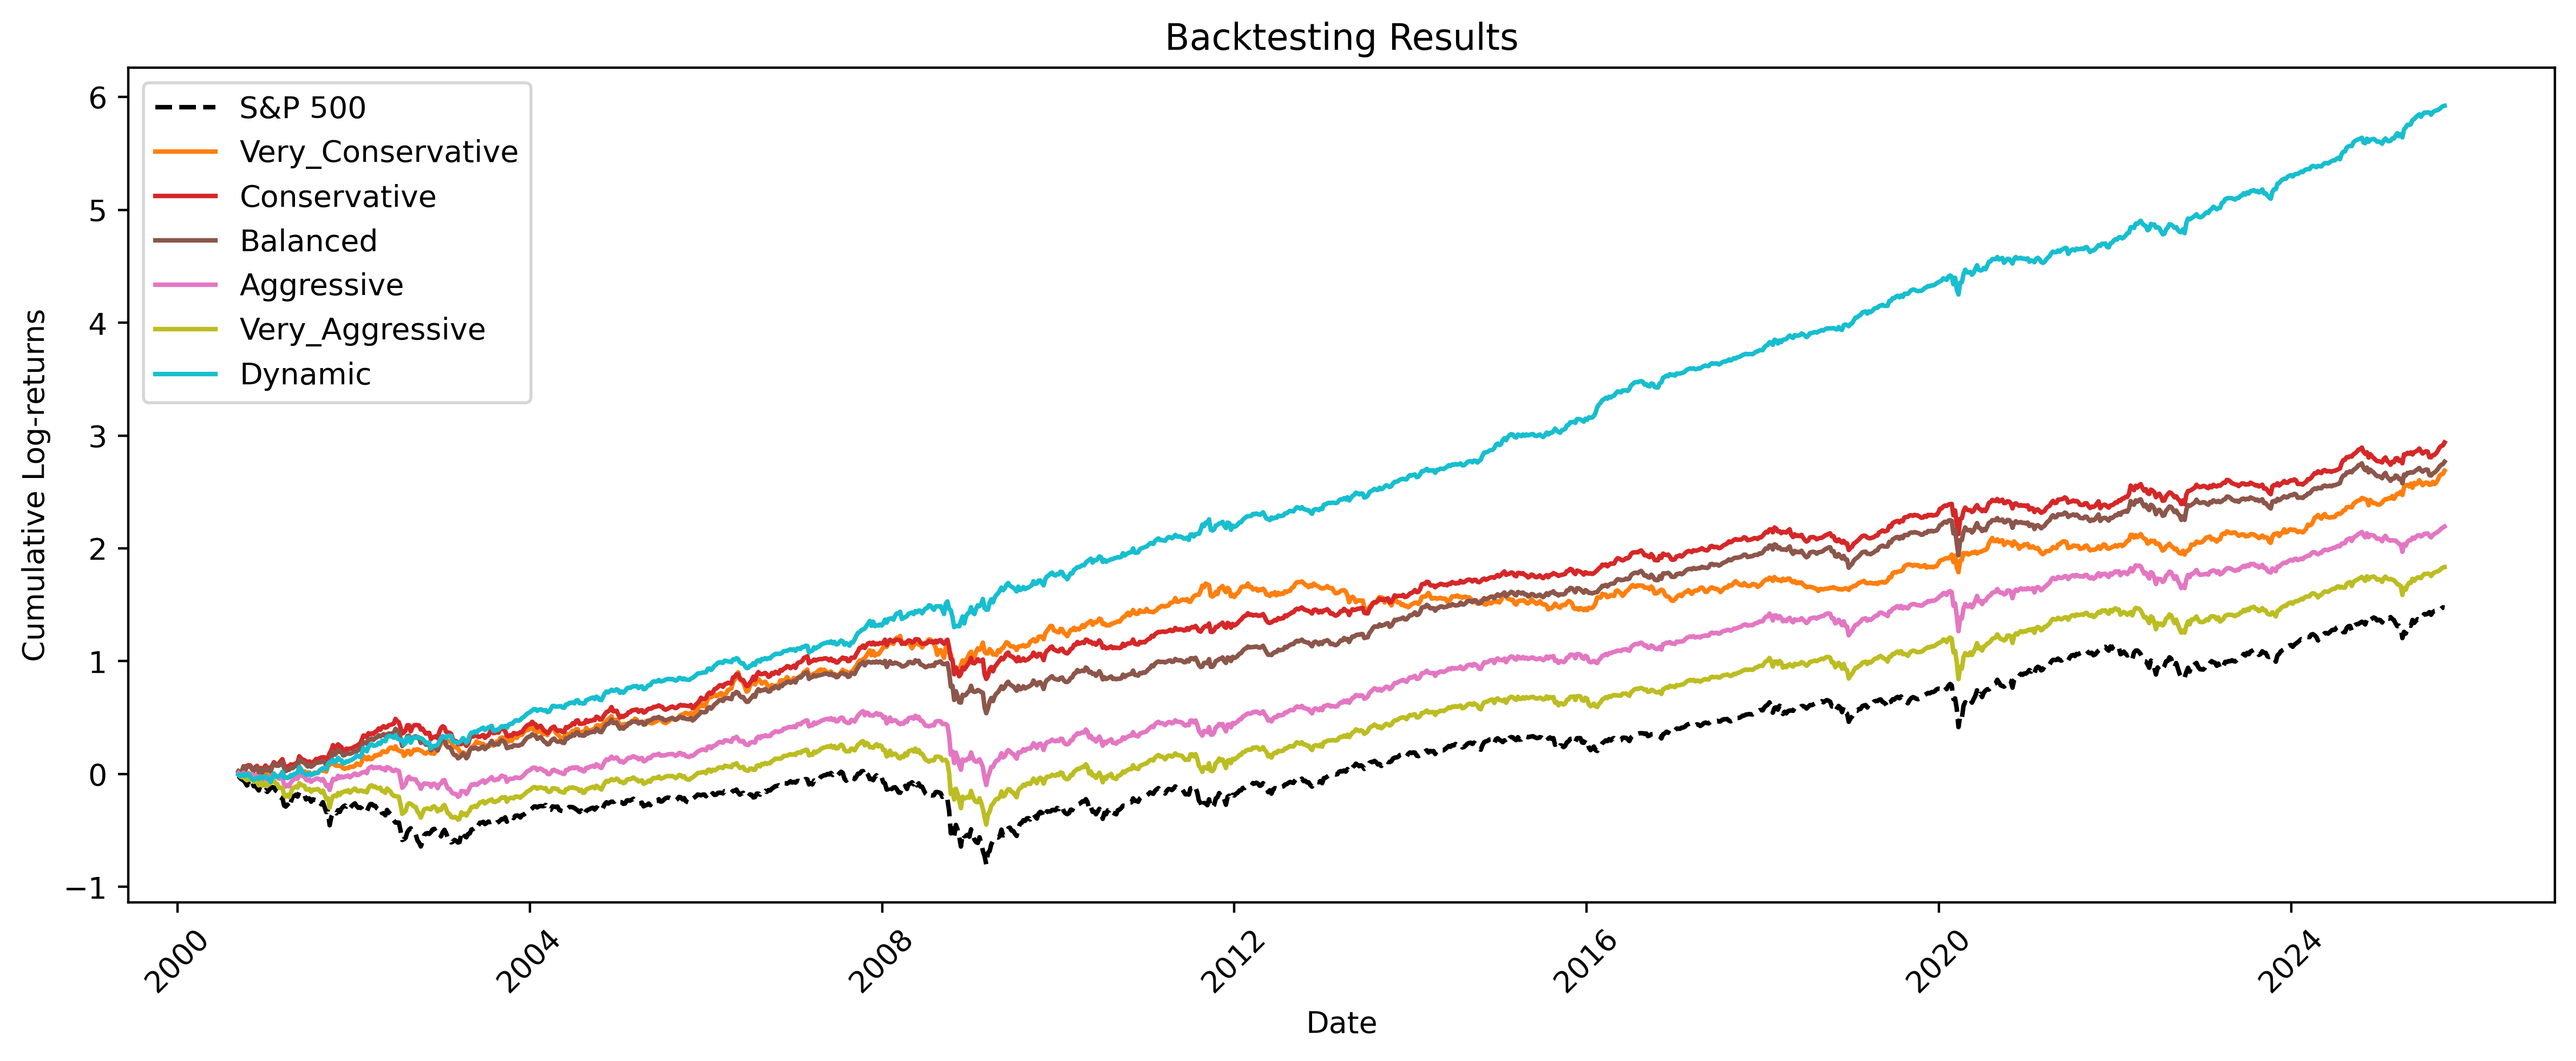

In [38]:
# 백테스팅 설정
base_fee = 0.0002  # 기본 수수료 0.02%
turnover_multiplier = 1  # turnover에 따른 수수료 증가 배수
rebalance_freq = 'W'  # 리밸런싱 주기: 'D', 'W', 'M', 'Q', 'Y'

print(f"설정:")
print(f"  - 기본 수수료: {base_fee*100:.2f}%")
print(f"  - Turnover 배수: {turnover_multiplier}")
print(f"  - 리밸런싱 주기: {rebalance_freq}")

# 백테스팅 실행
result_df = pd.DataFrame()
for str_name in weight_dict.keys():
    result_df = bt.return_Table(
        weight_dict[str_name], 
        data['Close'],  # 가격 데이터 직접 전달
        result_df,
        rebalance_freq=rebalance_freq,
        fee=base_fee,
        turnover_multiplier=turnover_multiplier
    )
    
# 컬럼명 설정 (S&P 500 + 전략들)
result_df.columns = ['S&P 500'] + list(weight_dict.keys())

bt.plot_result(result_df)

In [40]:
for freq in ['D', 'W', 'M', 'Q', 'Y']:  
    # turnover 계산 (예: 월별 리밸런스)
    turnover_per_period = bt.cal_turnover(weight_dict['Dynamic'], rebalance_freq=freq)

    # 수수료 효과 계산
    fee_log = bt.cal_dynamic_fee(turnover_per_period, fee=0.0002, turnover_multiplier=1)

    # 총 수수료 (log-return 기준 합산)
    total_fee = fee_log.sum()
    print(f"{freq} turnover_mean: {turnover_per_period.mean():.4f}")
    print(f"{freq} 총 수수료 (log return 합): {total_fee:.4f}")


D turnover_mean: 0.0523
D 총 수수료 (log return 합): -0.2697
W turnover_mean: 0.1559
W 총 수수료 (log return 합): -0.1127
M turnover_mean: 0.3087
M 총 수수료 (log return 합): -0.0507
Q turnover_mean: 0.3490
Q 총 수수료 (log return 합): -0.0191
Y turnover_mean: 0.4404
Y 총 수수료 (log return 합): -0.0061


In [41]:
metric = bt.METRICS(result_df.dropna())
metric.cal_describe()
metric.cal_monthly_statistics()

In [42]:
metric.annual_statistics

,S&P 500,Very_Conservative,Conservative,Balanced,Aggressive,Very_Aggressive,Dynamic
Date,2000-09-10 ~ 2025-09-28,2000-09-10 ~ 2025-09-28,2000-09-10 ~ 2025-09-28,2000-09-10 ~ 2025-09-28,2000-09-10 ~ 2025-09-28,2000-09-10 ~ 2025-09-28,2000-09-10 ~ 2025-09-28
count,1308,1308,1308,1308,1308,1308,1308
cumulative return,336.86423,1369.24545,1788.66769,1492.34353,796.71491,525.8935,37226.1033
annualized return mean,0.06037,0.11275,0.12392,0.11632,0.09112,0.07564,0.26547
annualized return std,0.19391,0.15612,0.1586,0.16283,0.16549,0.17501,0.14471
annualized return downside std,0.15696,0.11113,0.12321,0.13141,0.1372,0.1448,0.10744
sharpe ratio,0.31132,0.7222,0.78133,0.71436,0.5506,0.43217,1.83455
sortino ratio,0.38461,1.01459,1.00575,0.88514,0.66416,0.52233,2.47078
gross profit,12.00443,11.22023,11.17592,11.10133,10.79838,11.10358,12.11902
gross loss,-10.52997,-8.5329,-8.23746,-8.33354,-8.60482,-9.26957,-6.19674


In [43]:
metric.monthly_statistics

,S&P 500,Very_Conservative,Conservative,Balanced,Aggressive,Very_Aggressive,Dynamic
Mean,0.00113,0.00205,0.00225,0.00212,0.00168,0.0014,0.00453
Standard deviation,0.02458,0.02012,0.02041,0.02092,0.02124,0.02237,0.01874
Standard error,0.00068,0.00056,0.00056,0.00058,0.00059,0.00062,0.00052
t-statistic,1.7523,3.9872,4.2284,3.8878,3.0443,2.4095,10.0813
Min,-0.20084,-0.10532,-0.12973,-0.13366,-0.17215,-0.18649,-0.10532
25%,-0.01031,-0.00876,-0.00791,-0.00794,-0.00796,-0.00834,-0.00514
50%,0.00249,0.00288,0.00352,0.0033,0.00317,0.00298,0.00471
75%,0.01436,0.01386,0.01366,0.01346,0.01277,0.01295,0.01467
Max,0.11424,0.10384,0.13541,0.13655,0.12139,0.10954,0.10384
Skew,-0.88703,-0.36328,-0.65195,-0.79709,-0.96688,-0.95527,-0.32196


In [33]:
metric.save_results('./general_results')